In [268]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pyxdf
import neurokit2 as nk
np.trapezoid = np.trapz # Monkey patch for numpy version issue with Neurokit

In [269]:
# Importing data from XDF
xdf_file = "data/1_20_26_a.xdf"
streams, header = pyxdf.load_xdf(xdf_file)
t = {} # Time stamps
x = {} # Time series
fs = {} # Sampling rates
t_0 = 60 # Mask start time (s)
t_f = 60*21 # Mask end time (s)
for s in streams:
    name = s["info"]["name"][0]
    t[name] = np.array(s["time_stamps"]) - s["time_stamps"][0]
    x[name] = np.array(s["time_series"])
    fs[name] = 1 / np.median(np.diff(t[name]))
    mask = (t_0 <= t[name]) & (t[name] <= t_f)
    t[name] = t[name][mask]
    x[name] = x[name][mask]

Stream 3: Calculated effective sampling rate 611.8225 Hz is different from specified rate 1000.0000 Hz.


In [270]:
# Running ECG through Neurokit pipeline
ecg_name = "ECG_Stream"
ecg_raw = (((x[ecg_name] / 4096 * 3.3) - (3.3 / 2)) / 1100) * 1000
ecg_fs = fs[ecg_name]
ecg_clean = nk.ecg_clean(ecg_raw, sampling_rate=ecg_fs) # method = "neurokit"
_, ecg_peaks_info = nk.ecg_peaks(ecg_clean, sampling_rate=ecg_fs)
ecg_peaks_times = [t[ecg_name][i] for i in ecg_peaks_info["ECG_R_Peaks"]]

Average signal quality: 85.57%


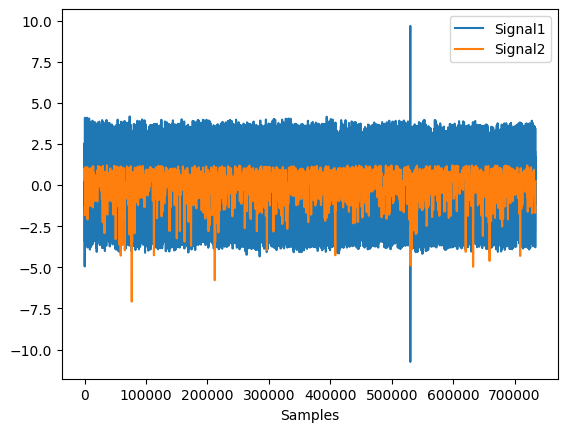

In [271]:
# Quality assessment
ecg_quality = nk.ecg_quality(ecg_clean, sampling_rate=ecg_fs)
nk.signal_plot([ecg_clean, ecg_quality], standardize=True)
print(f"Average signal quality: {(np.average(ecg_quality) * 100):.2f}%")

In [272]:
# Filtering
ecg_rr = np.diff(ecg_peaks_times)  # seconds

def ratio_filter(rr, threshold=0.3):
    if len(rr) == 0:
        return rr
    filtered = [rr[0]]
    for i in range(1, len(rr)):
        prev = filtered[-1]
        if abs(rr[i] - prev) / prev <= threshold:
            filtered.append(rr[i])
    return np.array(filtered)

ecg_rr_filtered = ratio_filter(ecg_rr)

# Stats
total_intervals = len(ecg_rr)
kept_intervals = len(ecg_rr_filtered)
kept_percent = (kept_intervals / total_intervals * 100) if total_intervals > 0 else 0
print(f"RR intervals retained: {kept_intervals}/{total_intervals} ({kept_percent:.2f}%)")

peaks_ts_filtered = np.cumsum(np.insert(ecg_rr_filtered, 0, 0))
peaks_idx_filtered = np.round(peaks_ts_filtered * ecg_fs).astype(int)
signal_length = int(peaks_idx_filtered[-1] + ecg_fs)  # 1s padding
ecg_peaks = np.zeros(signal_length, dtype=int)
ecg_peaks[peaks_idx_filtered] = 1

RR intervals retained: 1263/1811 (69.74%)


,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN
0,635.490902,94.940993,23.429025,91.861434,21.950454,92.023601,5.566059,94.788885,93.973782,94.010859,...,125.853505,1.010292,558.985699,710.990581,63.499604,85.035629,353.043599,939.815136,23.830189,437.5


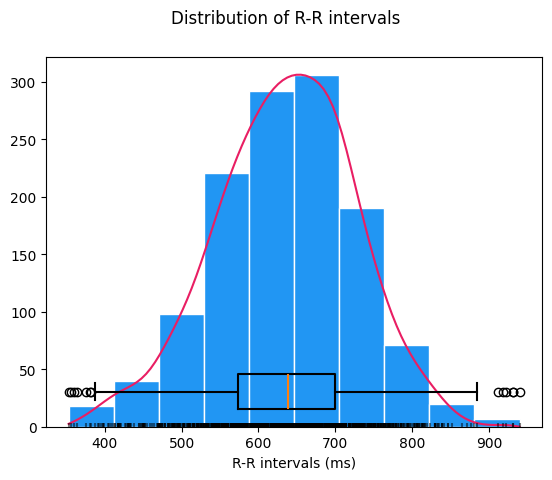

In [273]:
# Temporal analysis
ecg_hrv_time = nk.hrv_time(ecg_peaks, sampling_rate=ecg_fs, show=True)
ecg_hrv_time

,HRV_ULF,HRV_VLF,HRV_LF,HRV_HF,HRV_VHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF
0,NaN,0.007904,0.012889,0.014091,0.002493,0.037376,0.914679,0.344831,0.376997,-4.262237


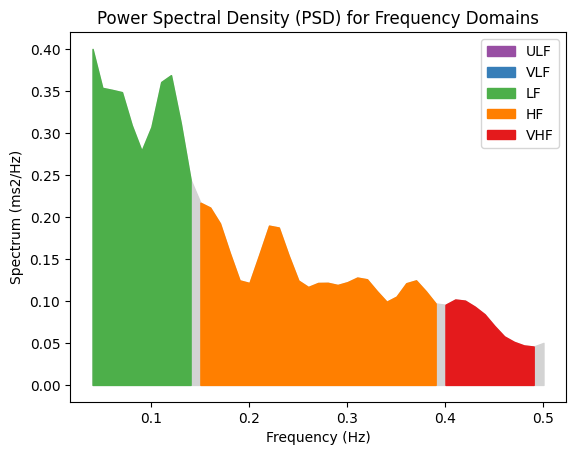

In [280]:
# Frequency analysis
ecg_hrv_freq = nk.hrv_frequency(ecg_peaks, sampling_rate=ecg_fs, show=True, normalize=True)
ecg_hrv_freq

,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,66.475716,116.600856,0.570113,24350.878472,1.754037,5.093485,818.088802,0.642914,0.641946,0.873292,...,2.034029,7.681904,1.391332,1.444136,1.410906,2.129594,1.872699,1.892432,4.674882,0.929929


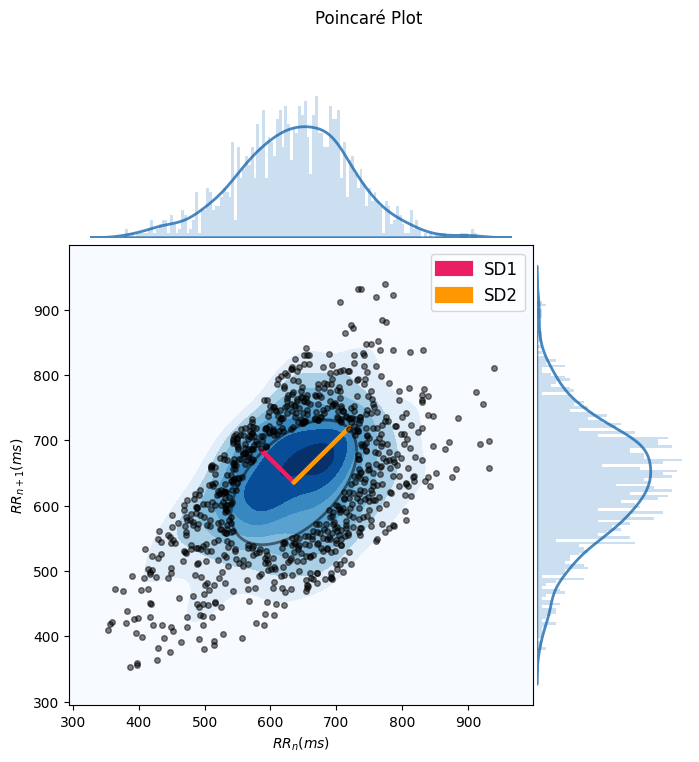

In [275]:
# Nonlinear analysis
ecg_hrv_nonlinear = nk.hrv_nonlinear(ecg_peaks, sampling_rate=ecg_fs, show=True)
ecg_hrv_nonlinear